Two qubit errors
===============

This is a simulation of qubit errors with CX gates to give confidence that the noise model in Qiskit is working as expected.

A number of CX gates given by GATE_DEPTH are applied.  If EXTRA_X_GATE is True an additional two X gates are applied to the first qubit between each CX gate.

At present the calculation does not agree unless the extra X gates are added.

This is part of an MSc project on the Steane code.  Please see https://goldsmdn.github.io/ for full details.

Import the necessary function modules.

In [1]:
from qiskit import(
  QuantumCircuit,
  QuantumRegister,
  ClassicalRegister,
  execute,
  Aer)

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.visualization import plot_histogram

Define constants so the process flow can be controlled from one place:

In [2]:
SHOTS = 10000                            #Number of shots to run 
MEASURE_NOISE = 0.0                      #Measurement noise not relevant
SINGLE_GATE_DEPOLARISING = 0.0           #Single gate noise   
TWO_GATE_DEPOLARISING = 0.0102           #Two gate noise 

GATE_DEPTH = 12

EXTRA_X_GATE = False                     #Seems to work fine with an extra X gate

NOISE = True                             #Test with noise
SIMULATOR = Aer.get_backend('qasm_simulator')

Define the noise model

In [3]:
def get_noise(p_meas,s_gate,t_gate):

    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(s_gate, 1)
    error_gate2 = depolarizing_error(t_gate, 1)
    error_gate3 = error_gate2.tensor(error_gate2)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, 'measure') # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ['x', 'y', 'z', 'h', 's', 'sdg'])  # single qubit gate errors
    noise_model.add_all_qubit_quantum_error(error_gate3, ['cx', 'rxx', 'cz']) # two qubit gate error is applied to cx gates

    return noise_model

The expected number of cases where both qubits are in the excited state is calculated.  

In [4]:
expected = SHOTS * ( 1 - TWO_GATE_DEPOLARISING )** GATE_DEPTH * (1 - MEASURE_NOISE)

The circuit is set up and simulated

In [5]:
# The final state will depend of whether we have an odd or even number of gates.
if (GATE_DEPTH % 2) == 0:
    print(f'With {SHOTS} shots we expect to see instances {expected:.0f} of the |01> state.')
else:
    print(f'With {SHOTS} shots we expect to see instances {expected:.0f} of the |11> state.')
qr = QuantumRegister(2,'code_qubit')     # Two qubits
cr = ClassicalRegister(2,'syndrome_bit') # Two Syndrome bit
qc = QuantumCircuit(qr,cr)
initial_state = [0,1]   # Define initial_state as |1>
qc.reset(qr[0])
qc.reset(qr[1])
qc.x(qr[0])

for i in range(GATE_DEPTH):
    qc.cx(qr[0],qr[1])
    if EXTRA_X_GATE:
        qc.x(qr[0])
        qc.x(qr[0])

qc.measure(qr, cr)

noise_model = get_noise(MEASURE_NOISE,SINGLE_GATE_DEPOLARISING,TWO_GATE_DEPOLARISING)

if NOISE:
    result = execute(qc, SIMULATOR, noise_model=noise_model, shots=SHOTS).result()
else:
    result = execute(qc, SIMULATOR, shots=SHOTS).result()     
counts = result.get_counts(qc)
print(f' The results were {counts}')


With 10000 shots we expect to see instances 8842 of the |01> state.
 The results were {'01': 10000}


Note above that the convention used is |Qbit1 Qbit0>

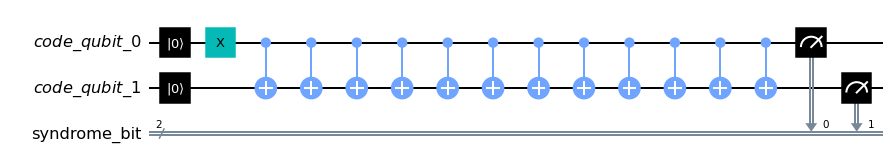

In [6]:
qc.draw(output='mpl', filename = 'Basic_two_qubit_errors_circuit.jpg', fold=60)

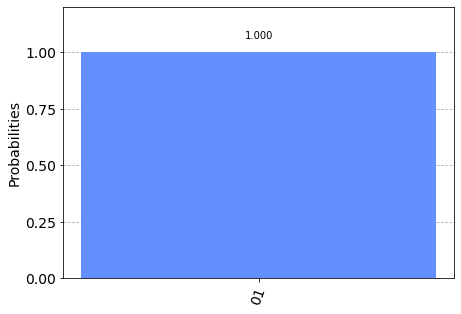

In [7]:
fname = "Basic_two_qubit_errors_histogram.png"
plot_histogram(counts).savefig(fname)
plot_histogram(counts)